In [12]:
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import * 

import torch.optim as optim


import sys
sys.path.insert(0,'/content')
from idlmam import *

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(42)
device = torch.device("cuda")

torch.set_printoptions(edgeitems=2, linewidth=75)

<ipython-input-12-23f2d1394521>:26: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


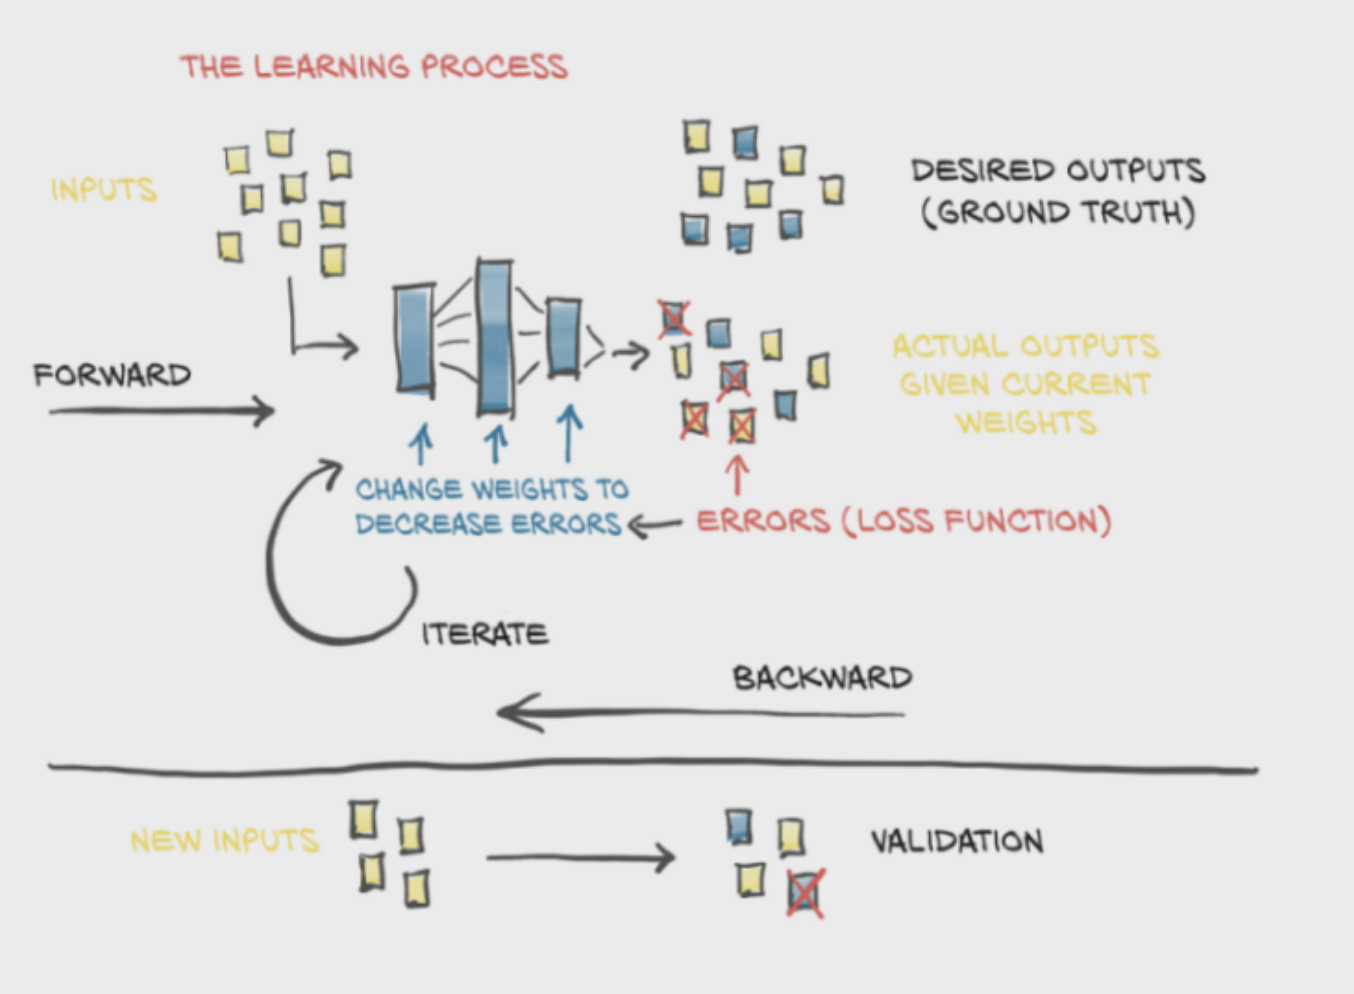

A big part of the reason neural networks have non-convex error surfaces is due to the activation function. The ability of an ensemble of neurons to approximate a very wide range of useful functions depends on the combination of the linear and nonlinear behavior inherent to each neuron.

We want to firmly constrain the output of our linear operation to a specific range so that the consumer of this output doesn’t have to handle numerical inputs

#OPTIMIZING BATCHES
The reason we want to do this batching is multifaceted. One big motivation is to make sure the computation we’re asking for is big enough to saturate the computing resources we’re using to perform the computation. GPUs in particular are highly parallelized, so a single input on a small model will leave most of the computing units idle. By providing batches of inputs, the calculation can be spread across the otherwise-idle units, which means the batched results come back just as quickly as a single result would.

In [7]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

In [8]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 1,  7,  6, 10,  9,  0,  3,  2,  4]), tensor([8, 5]))

In [10]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val


In [5]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

Epoch 1, Training loss 222.6774, Validation loss 52.9196
Epoch 1000, Training loss 47.4601, Validation loss 15.1260
Epoch 2000, Training loss 23.7681, Validation loss 15.1890
Epoch 3000, Training loss 12.4728, Validation loss 12.4668
Epoch 4000, Training loss 7.6062, Validation loss 9.6254
Epoch 5000, Training loss 5.8058, Validation loss 7.6922


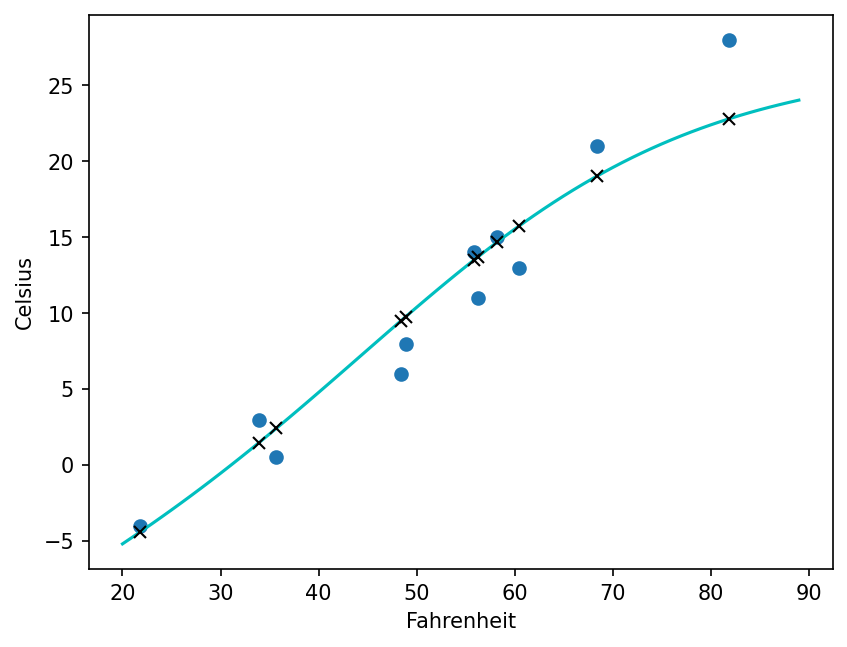

In [11]:
# Exercises here!
from collections import OrderedDict
neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

# #Telling Birds From Airplanes: Learning From Images

In [14]:
from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True) # <1>
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 79917929.89it/s]


Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7/
Files already downloaded and verified


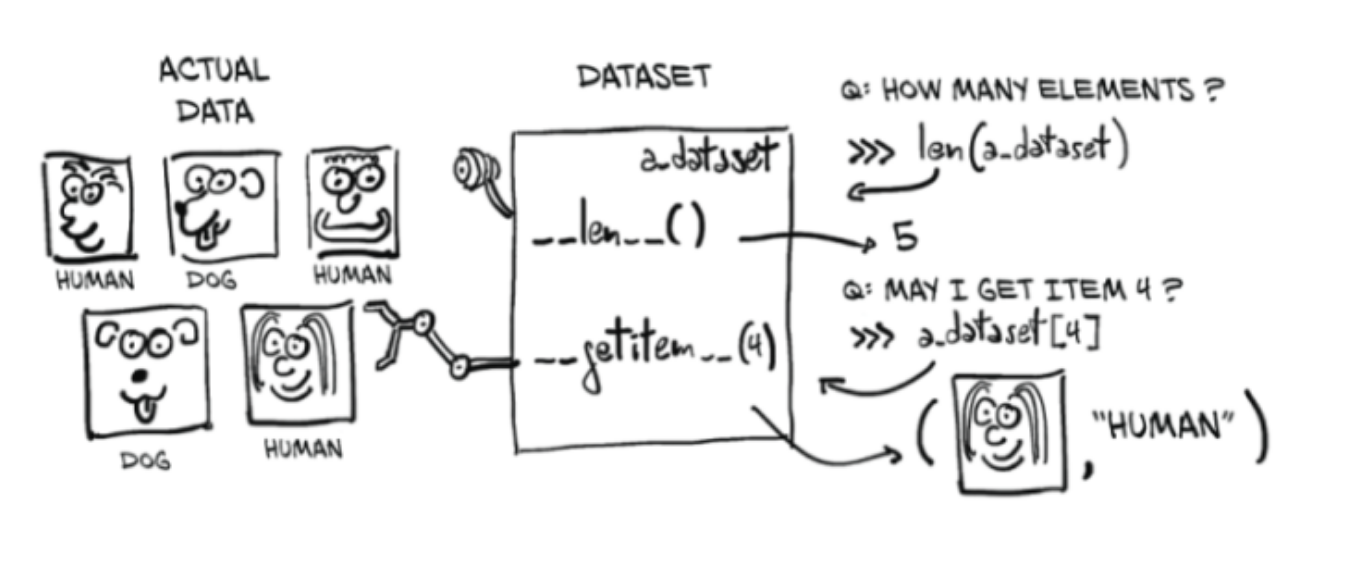

In [15]:
len(cifar10), type(cifar10).__mro__

(50000,
 (torchvision.datasets.cifar.CIFAR10,
  torchvision.datasets.vision.VisionDataset,
  torch.utils.data.dataset.Dataset,
  typing.Generic,
  object))

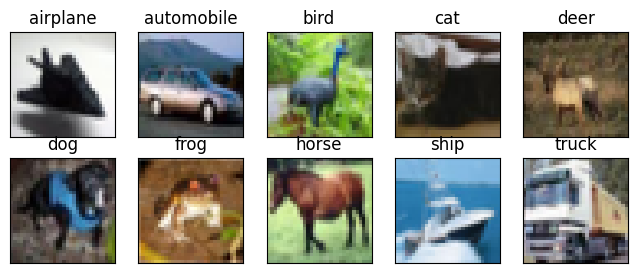

In [16]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

In [17]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F9F6F9F69B0>,
 1,
 'automobile')

#Dataset transforms

In [18]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

As we anticipated, we can pass the transform directly as an argument to dataset .CIFAR10:

In [19]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.ToTensor())

In [20]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [21]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

PyTorch torch.permute() rearranges the original tensor according to the desired ordering and returns a new multidimensional rotated tensor. The size of the returned tensor remains the same as that of the original.

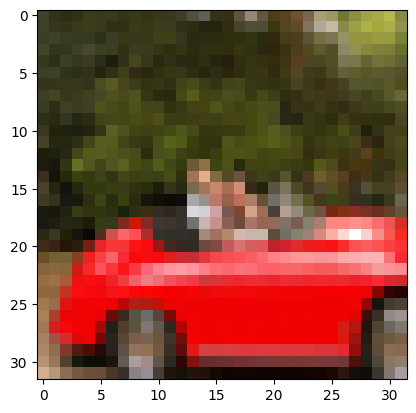

In [22]:
plt.imshow(img_t.permute(1, 2, 0))  # <1>
plt.show()

# Normalizing data
Transforms are really handy because we can chain them using transforms.Compose, and they can handle normalization and data augmentation transparently, directly in the data loader. For instance, it’s good practice to normalize the dataset so that each channel has zero mean and unitary standard deviation.

In [23]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

plt.imshow(img_t.permute(1, 2, 0))  # <1>
plt.show()

In [24]:
imgs.view(3, -1).mean(dim=1) 

tensor([0.4914, 0.4822, 0.4465])

In [25]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [26]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [27]:
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

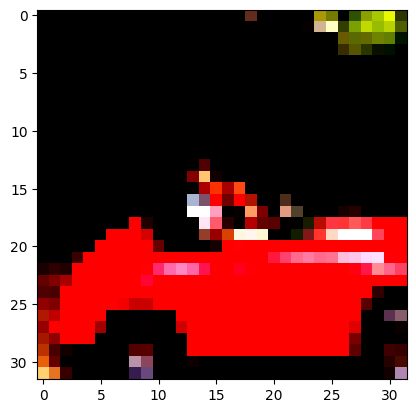

In [28]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()